### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import numpy as np
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import nrrd
import random
from omegaconf import OmegaConf
from typing import Iterable, Dict, Callable, Tuple, Union, List
from scipy.ndimage import binary_erosion, binary_dilation
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from scipy.ndimage import distance_transform_edt


sys.path.append('..')
from dataset import get_eval_dataset
from utils import get_features, evaluate_RF, add_background_bias
from model import get_model
from user_model import UserModel

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Boiler plate

In [4]:
# Load config
cfg = OmegaConf.load('../configs/eval_uncertainty.yaml')
cfg.soft_scores = True

In [7]:
verbose = True

# get dataset
dataset = get_eval_dataset(
    cfg=cfg,
    initial_annotation=True,
    verbose=verbose
)

# get model and load state dict
model, state_dict = get_model(
    cfg=cfg,
    return_state_dict=True,
    verbose=verbose
)
model.load_state_dict(state_dict)

# get features
features = get_features(
    model=model,
    dataset=dataset,
    feature=cfg.feature,
    verbose=verbose
)

# get results
uncertainty_measures = [
    cfg.uncertainty_measure
]
if cfg.background_bias:
    uncertainty_measures.append('feature-distance')

Loading dataset for subject 599469 with labels set1 ...
Sampling initial annotations ...
Done.

Loading model: zero -> reconstruction with spatial dim 145 and Dropout False

Done. Returning model and state dict ae_feature-extractor_all_old.pt.

Extracting features...
Extracting TTA features...
Done.



In [34]:
dataset = get_eval_dataset(
    cfg=cfg,
    initial_annotation=True,
    verbose=verbose
)

Loading dataset for subject 599469 with labels set1 ...
Sampling initial annotations ...
Done.



In [35]:
img = dataset.data_in[75]

In [9]:
scores, prediction, uncertainty_maps, uncertainty_per_class_maps, t = evaluate_RF(
    dataset=dataset, 
    features=features, 
    cfg=cfg,
    uncertainty_measures=uncertainty_measures
)


for i in range(1):
    u_annots = dataset.user.random_refinement_annotation(
        prediction=prediction,
        annotation_mask=dataset.annotations.detach().cpu(),
        brain_mask=dataset.brain_mask.detach().cpu(),
        n_samples=cfg.init_voxels,
        mode='per_class',
        seed=42
    )

    dataset.update_annotation(u_annots)

1 90
2 84
1 73
0 25
0 20


In [36]:
scores, prediction, uncertainty_maps, uncertainty_per_class_maps, t = evaluate_RF(
    dataset=dataset, 
    features=features, 
    cfg=cfg,
    uncertainty_measures=uncertainty_measures
)

In [37]:
background_class = torch.zeros(len(cfg.data.labels[cfg.data.labelset]))
background_class[0] = 1
bb_flipped_voxels = prediction.clone()
prediction_bb = add_background_bias(
    prediction=prediction,
    anomaly_score_map=uncertainty_maps['feature-distance'],
    background_class=background_class,
    threshold=t
)

In [38]:
(prediction != bb_flipped_voxels).sum((0,2,3)).sort()

torch.return_types.sort(
values=tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    3,   25,   34,   88,  198,  255,  461,  482,  532,
         560,  608,  619,  627,  635,  638,  652,  659,  663,  688,  688,  690,
         700,  702,  719,  736,  745,  758,  759,  759,  765,  776,  778,  780,
         786,  798,  805,  819,  830,  837,  838,  844,  851,  869,  885,  885,
         932,  954,  960,  960,  966,  995, 1030, 1033, 1038, 1043, 1048, 1050,
        1053, 1089, 1123, 1139, 1144, 1184, 1226, 1238, 1252, 1288, 1297, 1375,
        1390, 1398, 1425, 1434, 1452, 1461, 1492, 1492, 1551, 1558, 1558, 1595,
        1596, 1645, 1706, 1714, 1730, 1743, 1753, 1771, 1787, 1830, 1831, 1847,
        1870, 1888, 1889, 1912, 1915, 1936, 1967, 2018, 2033, 2034, 2034, 2053,
        2091, 2095, 2162, 2198, 2235, 2292, 2314, 2330, 2330, 2340, 2408, 2411,
        2437, 2462, 2508, 2624, 2812, 3111, 3179, 3228, 3240, 3496, 3642, 3855,
        

In [51]:
dataset.label.shape

torch.Size([5, 145, 145, 145])

110


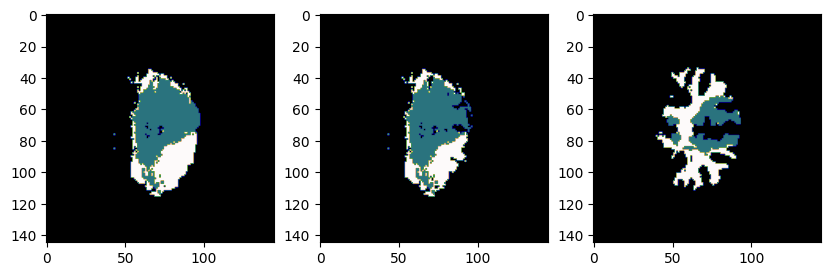

117


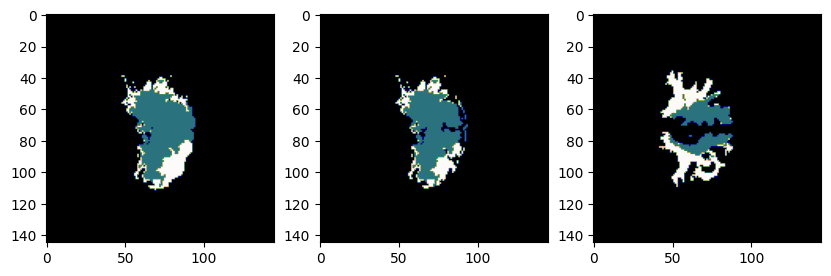

91


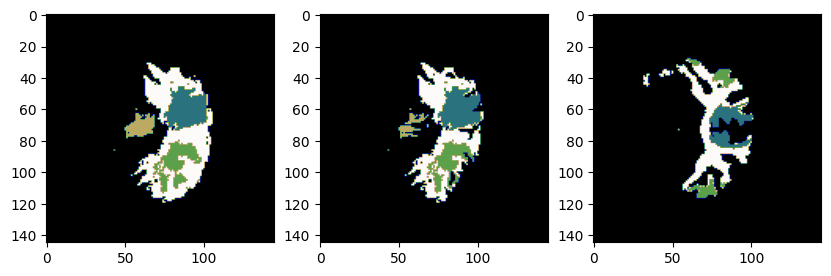

75


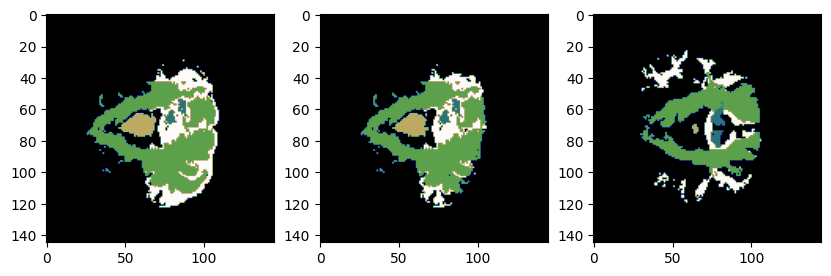

64


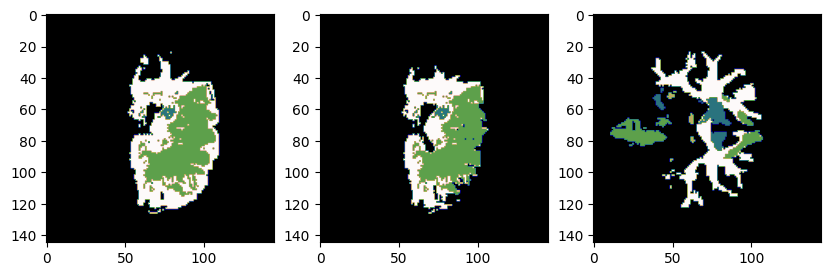

34


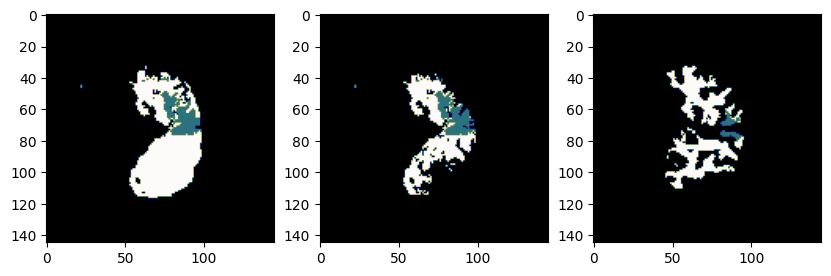

In [52]:
indices = [
    110,
    117,
    91,
    75,
    64,
    34
]
for idx in indices:
    print(idx)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(bb_flipped_voxels.argmax(0)[idx], cmap='gist_earth')
    axes[1].imshow(prediction.argmax(0)[idx], cmap='gist_earth')
    axes[2].imshow(dataset.label.argmax(0)[idx], cmap='gist_earth')
    plt.show()


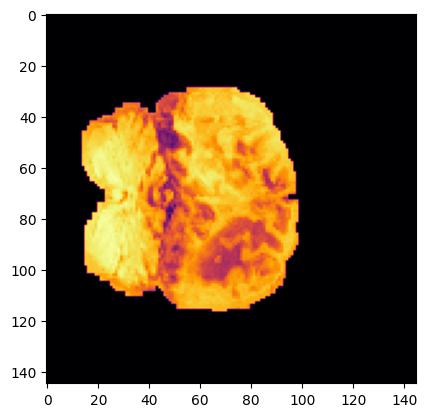

In [59]:
plt.imshow(uncertainty_maps['entropy'][34], cmap='inferno')

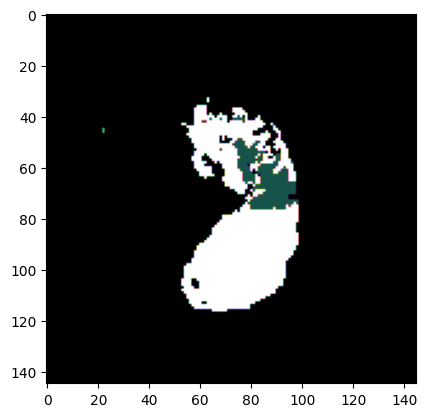

In [63]:
plt.imshow(bb_flipped_voxels.argmax(0)[34], cmap='cubehelix')

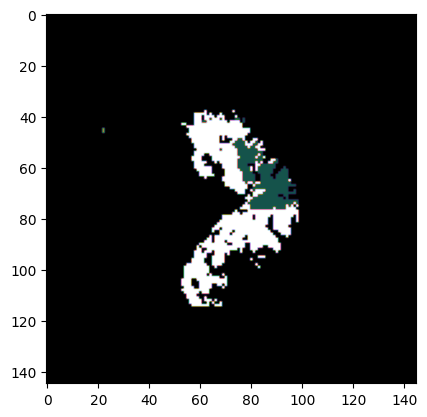

In [62]:
plt.imshow(prediction.argmax(0)[34], cmap='cubehelix')

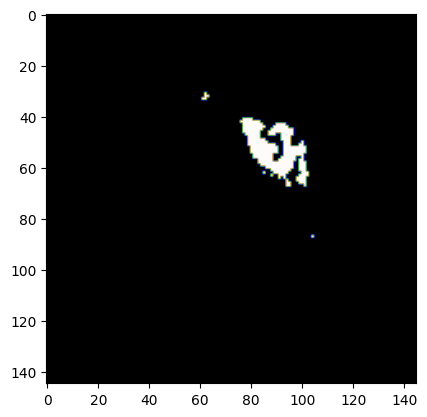

In [32]:
plt.imshow(prediction.argmax(0)[50] != bb_flipped_voxels.argmax(0)[50], cmap='gist_earth')

In [61]:
(prediction_bb != prediction).sum()

tensor(0)

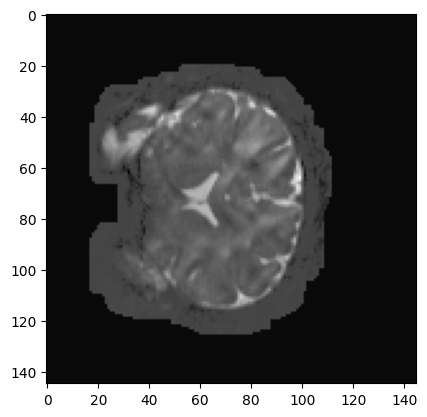

In [16]:
feature_out = features[0][100, :, :, 0].copy()
feature_out = (feature_out - feature_out.min()) / (feature_out.max() - feature_out.min())
plt.imshow(1 - feature_out, cmap='gray')

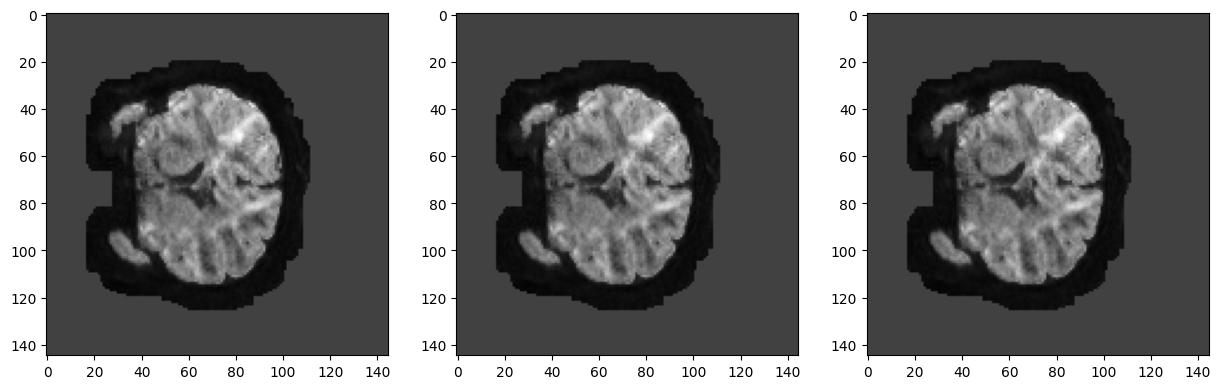

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    
    feature_out = features[i][100, :, :, 1].copy()
    # feature_out = (feature_out - feature_out.min()) / (feature_out.max() - feature_out.min())
    axes[i].imshow(feature_out, cmap='gray')

# feature_out = features[0][100, :, :, 3].copy()
# feature_out = (feature_out - feature_out.min()) / (feature_out.max() - feature_out.min())
# plt.imshow(feature_out, cmap='gray')

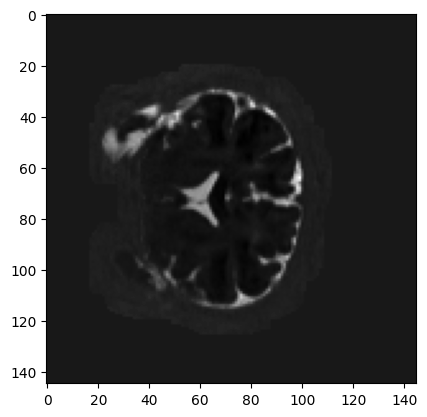

In [57]:
feature_out = features[0][100, :, :, 7].copy()
feature_out = (feature_out - feature_out.min()) / (feature_out.max() - feature_out.min())
plt.imshow(feature_out, cmap='gray')

In [7]:
### Load data for quali comparison

cfg.data.subject = 987983
cfg.data.labelset = 'set1'

In [20]:
verbose = True
cfg.data.subject = 987983
# get dataset
cfg.data.labelset = 'set1'
dataset_set1 = get_eval_dataset(
    cfg=cfg,
    initial_annotation=False,
    verbose=verbose
)
cfg.data.labelset = 'set2'
dataset_set2 = get_eval_dataset(
    cfg=cfg,
    initial_annotation=False,
    verbose=verbose
)

Loading dataset for subject 987983 with labels set1 ...
Done.

Loading dataset for subject 987983 with labels set2 ...
Done.



In [53]:
pred_set1 = torch.load('../../results/data/collection/results_baseline_set1.pt')
pred_set2 = torch.load('../../results/data/collection/results_baseline_set2.pt')
baseline_set1 = torch.load('../../results/data/collection/results_set1.pt')
baseline_set2 = torch.load('../../results/data/collection/results_set2.pt')
gt_set1 = dataset_set1.label.clone()
gt_set2 = dataset_set2.label.clone()

In [25]:
import nibabel as nib

In [56]:
for i, c in enumerate(pred_set1):
    nii_file = nib.Nifti1Image(c.float().numpy(), np.eye(4))
    nib.save(nii_file, f'../../results/data/collection/set1/pred_set1_{i}.nii.gz')



In [57]:
for i, c in enumerate(baseline_set1):
    nii_file = nib.Nifti1Image(c.float().numpy(), np.eye(4))
    nib.save(nii_file, f'../../results/data/collection/set1/baseline_set1_{i}.nii.gz')

In [ ]:
for i, c in enumerate(gt_set1):
    nii_file = nib.Nifti1Image(c.float().numpy(), np.eye(4))
    nib.save(nii_file, f'../../results/data/collection/set1/gt_set1{i}.nii.gz')

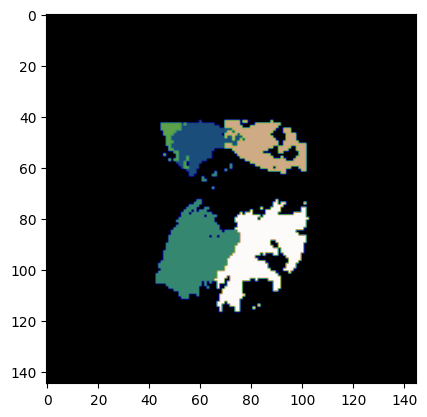

In [46]:
plt.imshow(baseline_pred_set2.argmax(0)[50], cmap='gist_earth')

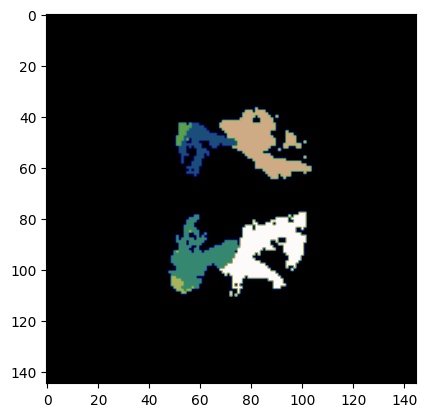

In [23]:
plt.imshow(baseline_set2.argmax(0)[50], cmap='gist_earth')

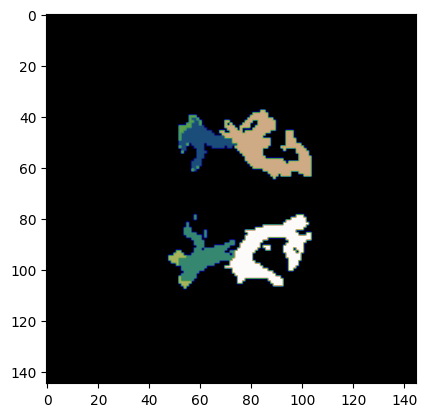

In [24]:
plt.imshow(gt_set2.argmax(0)[50], cmap='gist_earth')